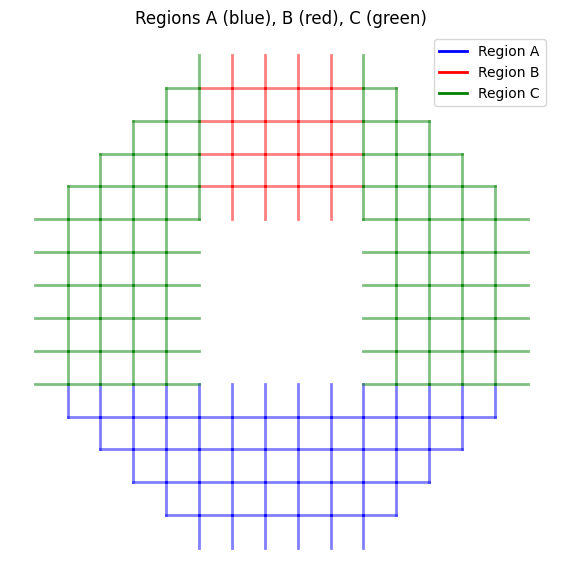

setA: {((12, 4), 'H'), ((14, 9), 'H'), ((12, 3), 'H'), ((10, 1), 'V'), ((11, 11), 'H'), ((12, 6), 'H'), ((11, 9), 'H'), ((14, 10), 'V'), ((12, 8), 'H'), ((10, 3), 'V'), ((12, 12), 'V'), ((13, 7), 'V'), ((11, 10), 'H'), ((10, 2), 'V'), ((13, 8), 'V'), ((11, 13), 'H'), ((12, 7), 'H'), ((13, 10), 'V'), ((13, 5), 'V'), ((12, 9), 'H'), ((10, 5), 'V'), ((11, 2), 'V'), ((14, 10), 'H'), ((13, 6), 'V'), ((11, 3), 'V'), ((12, 5), 'H'), ((12, 12), 'H'), ((12, 10), 'V'), ((13, 7), 'H'), ((13, 4), 'V'), ((13, 11), 'V'), ((14, 5), 'V'), ((10, 6), 'V'), ((14, 7), 'V'), ((13, 8), 'H'), ((13, 3), 'H'), ((13, 10), 'H'), ((11, 5), 'V'), ((13, 5), 'H'), ((11, 12), 'H'), ((11, 4), 'V'), ((14, 8), 'V'), ((11, 2), 'H'), ((13, 9), 'V'), ((12, 11), 'V'), ((14, 6), 'V'), ((13, 6), 'H'), ((10, 10), 'V'), ((11, 7), 'V'), ((10, 12), 'V'), ((12, 10), 'H'), ((13, 4), 'H'), ((14, 5), 'H'), ((14, 9), 'V'), ((14, 7), 'H'), ((10, 8), 'V'), ((10, 11), 'V'), ((13, 9), 'H'), ((10, 13), 'V'), ((12, 11), 'H'), ((12, 8), 'V')

In [49]:
import jax
import jax.numpy as jnp
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import random
import math
from itertools import chain
import string
from functools import partial
from jax import config
config.update("jax_enable_x64", True)
def get_edges(n):
    '''
    left-top corner is (0, 0)
    The plaquette is made of two side rectangles (2n * n) and one middle square (n*n) with boundary removed except for the top boundary.
    '''
    edges = []
    # left-top corner
    for r in range(n):
        for c in range(n - 1, n - 1 - r, -1):
            edge = ((r,  c), 'H')
            edges.append(edge)

    for r in range(n):
        for c in range(n - 1, n - r -1 ,-1):
            edge = ((r,  c), 'V')
            edges.append(edge)

    for r in range(n):
        for c in range(r+1):
            if c != r :
                edge = ((r, 2 * n + c), 'H')
                edges.append(edge)
            edge = ((r, 2 * n + c), 'V')
            edges.append(edge)
            
            
    # Horizontal edges for the top-left and top-right block
    for r in range(n):
        for c in range(n):
            edge1 = ((n+r, c), 'H')
            edge2 = ((n+r, c + 2 * n), 'H')
            edges.append(edge1)
            edges.append(edge2)

    # Vertical edges for the top-left and top-right block
    for r in range(n):
        for c in range(n):
            edge1 = ((n+r, c), 'V')
            if c == 0:
                continue
            edges.append(edge1)
    for r in range(n):
        for c in range(n):
            edge2 = ((n+r, c + 2 * n), 'V')
            if c == 0 and r < n:
                continue
            edges.append(edge2)
    # left-bottom corner
    for r in range(n):
        for c in range(n - r - 1, -1, -1):
            edge = ((2*n + r, r + c), 'H')
            edges.append(edge)

    for r in range(n):
        for c in range(n - r):
            edge = ((2*n + r, n - c), 'V')
            edges.append(edge)
    # right-bottom corner
    for r in range(n):
        for c in range(n - r, 0, -1):
            edge = ((2*n + r, 3 * n - (r + c)), 'H')
            edges.append(edge)
    for r in range(n):
        for c in range(n - r):
            edge = ((2*n + r, 2 * n + c), 'V')
            edges.append(edge)

    # Vertical edges for the left for the middle square
    for i in range(n):
        edge = ((2*n + i, n), 'V')
        edges.append(edge)
        edge = ((i, n), 'V')
        edges.append(edge)
    # Horizontal edges for the middle square
    for r in range(n - 1):
        for c in range(n):
            edge = ((r + 2*n + 1, c + n), 'H')
            edges.append(edge)
            edge = ((r + 1, c + n), 'H')
            edges.append(edge)
    # Vertical edges for the middle square
    for r in range(n):
        for c in range(n - 1):
            edge = ((r + 2*n, c + n + 1), 'V')
            edges.append(edge)
            edge = ((r, c + n + 1), 'V')
            edges.append(edge)
    return edges


def edges_of_plaquette(r, c):
    """
    Return the 4 canonical edges of the plaquette with top-left corner (r,c).
    """
    return [((r, c), 'H'), ((r + 1, c), 'H'), ((r, c), 'V'), ((r, c + 1), 'V')]


def define_B_and_C(n):
    all_edges = set(get_edges(n))
    setC = set()
    for r in range(n):
        for c in range(n):
            for e in edges_of_plaquette(r, c + 2 * n):
                if e not in setC:
                    setC.add(e)
            for e in edges_of_plaquette(r, c):
                if e not in setC:
                    setC.add(e)
            for e in edges_of_plaquette(r + n, c):
                if e not in setC:
                    setC.add(e)
            for e in edges_of_plaquette(r + n, c + 2 * n):
                if e not in setC:
                    setC.add(e)
    C_vertex_boundary = [(n, 2 * n + i) for i in range(n + 1)]

    def left_below_edges(r, c):
        res = []
        if r > 0: res.append(((r, c - 1), 'H'))
        res.append(((r, c), 'V'))
        return res

    setB = set()
    # Extending the grid distance by n steps.
    for r in range(n):
        for c in range(n - 1):
            setB.add(((r, n + 1 + c), 'V'))
    for r in range(n-1):
        for c in range(n):
            setB.add(((r + 1, n + c), 'H'))
    setA = all_edges - setB - setC

    return setA, setB, setC


def plot_regions(n):
    """
    Plot the lattice showing regions A, B, and C in different colors.
    Region A: edges in A (blue)
    Region B: edges in B (red)
    Region C: edges in C (green)
    """

    allEdges = set(get_edges(n))
    setA, setB, setC = define_B_and_C(n)
    # Ensure each region only contains allowed edges.
    setA = setA.intersection(allEdges)
    setB = setB.intersection(allEdges)
    setC = setC.intersection(allEdges)
    plt.figure(figsize=(7, 7))

    # Plot all edges in A (blue)
    for edge in setA:
        (r, c), typ = edge
        if typ == 'H':
            x1, y1 = c, r
            x2, y2 = c + 1, r
        else:
            x1, y1 = c, r
            x2, y2 = c, r + 1
        plt.plot([x1, x2], [y1, y2], color='blue', lw=2, alpha=0.5)

    # Plot all edges in B (red)
    for edge in setB:
        (r, c), typ = edge
        if typ == 'H':
            x1, y1 = c, r
            x2, y2 = c + 1, r
        else:
            x1, y1 = c, r
            x2, y2 = c, r + 1
        plt.plot([x1, x2], [y1, y2], color='red', lw=2, alpha=0.5)

    # Plot all edges in C (green)
    for edge in setC:
        (r, c), typ = edge
        if typ == 'H':
            x1, y1 = c, r
            x2, y2 = c + 1, r
        else:
            x1, y1 = c, r
            x2, y2 = c, r + 1
        plt.plot([x1, x2], [y1, y2], color='green', lw=2, alpha=0.5)

    # Add a legend manually.
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Region A'),
                       Line2D([0], [0], color='red', lw=2, label='Region B'),
                       Line2D([0], [0], color='green', lw=2, label='Region C')]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title("Regions A (blue), B (red), C (green)")
    plt.xlim(-0.5, n + 0.5)
    plt.ylim(-0.5, n + 0.5)
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    print("setA:", setA)
    print("setB:", setB)
    print("setC:", setC)
    return setA, setB, setC


n = 5
setA, setB, setC = plot_regions(n)

all_plaq = list(chain(
    ((r, c) for r in range(1, n-1) for c in range(n, 2*n)), # top middle
    ((2*n + r, c) for r in range(1, n-1) for c in range(n, 2*n)),  # bottom middle
    ((r, c) for r in range(n, 2*n) for c in range(1, n-1)),
    ((r, 2*n+c) for r in range(n, 2*n) for c in range(1, n-1)),
    ((r, n-r+c) for r in range(n) for c in range(r)),
    ((r, 2*n+c) for r in range(n) for c in range(r)),
    ((2*n+r, c) for c in range(n) for r in range(c)),  
    ((2*n+r, 2*n+c) for c in range(n) for r in range(n-c-1)),
    ((n-1, n+c) for c in range(n)),
    ((2*n, n+c) for c in range(n)),
    ((n+r, n-1) for r in range(n)),
    ((n+r, 2*n) for r in range(n)),
))
plaq_dict = {key: 0. for key in all_plaq}

print("all_plaq:", all_plaq)
def region_plaquettes(regionEdges, all_plaq):
    """
    For a given set of allowed edges (regionE
    dges), return the list of plaquettes
    (by their top-left coordinate) that are partially contained in the region.
    """
    plaq = []
    for (r, c) in all_plaq:
        edges = [((r, c), 'H'),
                 ((r+1, c), 'H'),
                 ((r, c), 'V'),
                 ((r, c+1), 'V')]
        if any(e in regionEdges for e in edges):
            plaq.append((r, c))
    return plaq

In [35]:
plaq_dict[(1, 4)]

1

In [29]:
import jax.numpy as jnp
from functools import partial
def T_tensor(p):
    """
    Constructs the two-leg tensor that represents the weight on each edge.
    
    T_{s1 s2} = delta(s1,s2) * (p**s1)*((1-p)**(1-s1))
    It is a 2x2 diagonal matrix.
    """
    return jnp.array([[1-p, 0], [0, p]])

def boundary_T_tensor(p):
    return jnp.array([1-p, p])

def Q_tensor(m):
    """
    Constructs the four-leg tensor for a plaquette that enforces the parity.
    
    Q^m_{s1 s2 s3 s4} = 1 if (s1 + s2 + s3 + s4) mod 2 equals m, else 0.
    The tensor has shape (2,2,2,2).
    
    m should be 0 or 1.
    """
    Q = jnp.zeros((2, 2, 2, 2))
    # Loop over all 16 combinations of {s1, s2, s3, s4}.
    for s1 in (0, 1):
        for s2 in (0, 1):
            for s3 in (0, 1):
                for s4 in (0, 1):
                    parity = (s1 + s2 + s3 + s4) % 2
                    # If parity matches the anyon measurement, set entry to 1.
                    value = 1 if parity == m else 0
                    Q = Q.at[s1, s2, s3, s4].set(value)
    return Q

def incomplete_Q_tensor(m):
    Q = jnp.zeros((2, 2, 2))
    # Loop over all 16 combinations of {s1, s2, s3, s4}.
    for s1 in (0, 1):
        for s2 in (0, 1):
            for s3 in (0, 1):
                parity = (s1 + s2 + s3) % 2
                # If parity matches the anyon measurement, set entry to 1.
                value = 1 if parity == m else 0
                Q = Q.at[s1, s2, s3].set(value)
    return Q

def full_tensor(m, p):

    tensor_list = []
    Q = Q_tensor(m)
    T = T_tensor(p)
    tensor_list.append(Q)
    for i in range(4):
        tensor_list.append(T)
    einsum_str = 'ijkl,ia, jb, kc, ld->abcd'
    
    return jax.numpy.einsum(einsum_str, *tensor_list)

def incomplete_tensor(m, p):

    tensor_list = []
    Q = Q_tensor(m)
    T = T_tensor(p)
    bT = boundary_T_tensor(p)
    tensor_list.append(Q)
    for i in range(3):
        tensor_list.append(T)
    tensor_list.append(bT)
    einsum_str = 'ijkl, ia, jb, kc, l->abc'
    
    return jax.numpy.einsum(einsum_str, *tensor_list)


def corner_tensor(m, p):
    tensor_list = []
    Q = Q_tensor(m)
    T = T_tensor(p)
    bT = boundary_T_tensor(p)
    tensor_list.append(Q)
    for i in range(2):
        tensor_list.append(T)
    tensor_list.append(bT)
    tensor_list.append(bT)
    einsum_str = 'ijkl, ia, jb, k, l->ab'
    
    return jax.numpy.einsum(einsum_str, *tensor_list)

def inner_corner_tensor(m, p):
    tensor_list = []
    Q = Q_tensor(m)
    T = T_tensor(p)
    tensor_list.append(Q)
    for i in range(2):
        tensor_list.append(T)
    einsum_str = 'ijkl, ia, jb->abkl'
    
    return jax.numpy.einsum(einsum_str, *tensor_list)

def inner_edge_tensor(m, p):
    tensor_list = []
    Q = incomplete_Q_tensor(m)
    T = T_tensor(p)
    tensor_list.append(Q)
    einsum_str = 'ijk, ia->ajk'
    
    return jax.numpy.einsum(einsum_str, Q, T)

In [ ]:
def initial_top(n, plaq, p):
    """
    Build a list of n tensors corresponding to the top row.
    The leftmost and rightmost are boundary incomplete (shape (2,2)),
    while the ones in between are boundary full (shape (2,2,2)).
    """
    tensor_list = []
    
    m = plaq_dict[plaq[0]]
    tensor_list.append(incomplete_tensor(m, p))  # left boundary, shape (2,2)
    for i in range(n - 3):
        m = plaq_dict[plaq[i+1]]
        tensor_list.append(full_tensor(m, p))  # middle plaquettes, shape (2,2,2)
    m = plaq_dict[plaq[n-2]]
    tensor_list.append(inner_edge_tensor(m, p))  # right boundary, shape (2,2)
    return tensor_list


@partial(jax.jit, static_argnums=(0,))
def contract_top_boundary(n, plaq, p):
    """
    Contract a list of n top-boundary tensors from left to right.
    The free vertical indices remain, and internal (horizontal) indices are contracted.
    """
    # Define labels for the indices.
    label = string.ascii_letters
    # Initialize the tensor list.
    tensor_list = initial_top(n, plaq, p)
    '''
     0 - - n
        |
       2*n
       to 
     0 - - n
     1 - - n+1
        .
        .
        .
     n-1 -- 2*n-1   
    '''
    # Left boundary tensor: shape (2,2) → assign indices: [bottom_label[0], virtual_label[0]]
    top_term = label[0]+label[n]+label[2*n] 
    top_tensor = tensor_list[0]
    # Middle tensors (i = 2,..., n-1): shape (2,2,2,2)
    for i in range(1, n - 1):
        term = label[2*n] + label[i] + label[n + i] + label[2*n + 1]
        output_subscript = label[:i+1] + label[n:n+i+1] + label[2*n+1]
        einsum_subscript = top_term + "," + term + "->" + output_subscript
        top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[i])
        top_term = label[:i+1] + label[n:n+i+1] + label[2*n]

    # Rightmost tensor: shape (2,2,2)
    term = label[n - 1] + label[2*n] + label[2*n - 1]
    output_subscript = label[:2*n]
    einsum_subscript = top_term + "," + term + "->" + output_subscript
    top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[n - 1])

    return top_tensor


@partial(jax.jit, static_argnums=(0,))
def contract_boundary_bulk(n, plaq, p, top_tensor):
    """
    Contract the list of n bulk tensors with the top tensor from left to right.
         _ 2n+1
        |
        2n
       -n+1
    """
    label = string.ascii_letters
    tensor_list = initial_top(n, plaq, p)
    top_terms = label[:2*n-2]
    term = label[n-1]  + label[2*n-2] + label[2*n - 1]
    output_subscript = label[:n-1]+ label[2*n-1] + label[2*n-2] + label[n:2*n-2] 
    einsum_subscript = top_terms + "," + term + "->" + output_subscript
    
    top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[0])
    top_terms = label[:n] + label[2*n-2]+ label[n:2*n-2]

    for i in range(1, n - 2):
        term = label[n+i-1] + label[2*n-2] + label[2*n - 1] + label[2*n]
        output_subscript = label[:n+i-1] + label[2*n - 2] + label[2*n - 1] + label[n+i:2*n-2]
        einsum_subscript = top_terms + "," + term + "->" + output_subscript
        top_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[i])
        top_terms = label[:n+i] + label[2*n-2] + label[n+i:2*n-2]
    term = label[2*n - 3] + label[2*n-2] + label[2*n - 1]
    output_subscript = label[:2*n-3] + label[2*n - 1]
    einsum_subscript = top_terms + "," + term + "->" + output_subscript
    final_tensor = jnp.einsum(einsum_subscript, top_tensor, tensor_list[n - 2])

    return final_tensor

@partial(jax.jit, static_argnums=(0,))
def contract_ladder(n, plaq, p, initial_tensor):
    """
    Perform a ladder contraction over n tensors.
        | (2n)
      - (n+1)
      - (n+2)
        to
        
        - (2n+1
        |(2n+2)
       -(n+2)    
    
    """
    label = string.ascii_letters
    tensor = initial_tensor
    
    for i in range(n - 2):
        term1 = label[:2*n-2]
        term2 = label[n-1] + label[2*n-2]
        output_subscript = label[:n-1]+label[2*n-2] + label[n:2*n-2]
        einsum_subscript = term1 + "," + term2 + "->" + output_subscript
        tensor = jnp.einsum(einsum_subscript, tensor, corner_tensor(plaq[i, 0], p))
        
        for j in range(1, n - i):
            term2 = label[n + j - 1] + label[2*n-2] + label[2*n - 1] + label[2*n]
            output_subscript = label[:n+j-2] + label[2*n - 1] + label [2*n - 2] + label[n + j : 2*n]
            einsum_str = term1 + "," + term2 + "->" + output_subscript
            tensor = jnp.einsum(einsum_str, tensor, full_tensor(plaq[i, j], p))
            term1 = label[:n+j-1] + label[2*n-2] + label[n+j:2*n-2]
    # Final contraction step.

    corner = corner_tensor(plaq[n-2, 0], p)
    term2 = label[n-1] + label[2*n-2]
    output_subscript = label[:n-1] + label[n:2*n - 1]
    einsum_str = term1 + "," + term2 + "->" + output_subscript
    tensor = jnp.einsum(einsum_str, tensor, corner)

    return tensor

In [ ]:
def process_column(n, plaq, p, tensor):
    """
    Process a column of tensors in the lattice.
    """
    label = string.ascii_letters
    tensor1 = tensor
    term1 = label[:2*(n-2)]
    
    tensor2 = incomplete_tensor(plaq_dict[plaq[0]], p)
    term2 = label[n - 2] + label[2*(n-2)] + label[2*(n-2) + 1]
    output_str = label[:n-2] + label[2*(n-2) + 1] + label[2*(n-2)] + label[n-2+1:2*(n-2)]
    einsum_str = term1 + "," + term2 + "->" + output_str
    tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)
    term1 = label[:n-1] + label[2*(n-2)] + label[n-2+1:2*(n-2)]
    for j in range(1, n-3):
        tensor2 = full_tensor(plaq_dict[plaq[j]], p)
        term2 = label[n -2 + j] + label[2*(n-2)] + label[2*(n-2) + 1] + label[2*(n-2) + 2]
        output_str = label[:n-2+j] + label[2*(n-2) + 2] + label[2*(n-2) + 1] + label[n-2+j+1:2*(n-2)]
        einsum_str = term1 + "," + term2 + "->" + output_str
        tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)
        term1 = label[:n-2+j+1] + label[2*(n-2)] + label[n-2+j+1:2*(n-2)]
    tensor2 = incomplete_tensor(plaq_dict[plaq[n-3]], p)
    term2 = label[2*(n-2) - 1] + label[2*(n-2)] + label[2*(n-2) + 1]
    output_str = label[:2*(n-2)-2] + label[2*(n-2) + 1]
    einsum_str = term1 + "," + term2 + "->" + output_str
    tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)
    return tensor1
    

def H_B_tensor(n, plaq, p):
    label = string.ascii_letters
    tensor1 = incomplete_tensor(plaq_dict[plaq[0, 0]], p)
    term1 = label[0] + label[n - 2] + label[2*(n-2)]
    for i in range(n-4):
        tensor2 = full_tensor(plaq_dict[plaq[0, i+1]], p)
        term2 = label[i+1] + label[2*(n-2)]  + label[n - 2 + i + 1] + label[2*(n-2) + 1]
        output_str = label[:i+1] + label[n-2:n+i+2] + label[2*(n-2)+1]
        einsum_str = term1 + "," + term2 + "->" + output_str
        tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)
        term1 = label[:i+1] + label[n-2:n+i+2] + label[2*(n-2)]
    tensor2 = incomplete_tensor(plaq_dict[plaq[0, n-3]])
    term2 = label[n-3] + label[2*(n-2)] + label[2*(n-2) - 1]
    output_str = label[:2*(n-2)]
    einsum_str = term1 + "," + term2 + "->" + output_str
    tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)
    for i in range(1, n):
        tensor1 = process_column(n, plaq[i], p, tensor1)
    return tensor1

def ladder_tensor(n, plaq, p, tensor):
    label = string.ascii_letters
    for i in range(n - 2):
        term1 = label[:2*(n-2)]
        term2 = label[n-2] + label[2*(n-2)]
        output_subscript = label[:n-2]+label[2*(n-2)] + label[n-1:2*(n-2)]
        einsum_subscript = term1 + "," + term2 + "->" + output_subscript
        tensor = jnp.einsum(einsum_subscript, tensor, corner_tensor(plaq[i, 0], p))
        
        for j in range(n - i - 3):
            term2 = label[n + j - 1] + label[2*(n-2)] + label[2*(n-2) + 1] + label[2*(n-2)+2]
            output_subscript = label[:n+j-2] + label[2*(n-2)+ 2] + label [2*(n -2) + 1] + label[n + j : 2*n]
            einsum_str = term1 + "," + term2 + "->" + output_subscript
            tensor = jnp.einsum(einsum_str, tensor, full_tensor(plaq[i, j], p))
            term1 = label[:n+j-1] + label[2*n-2] + label[n+j:2*n-2]
        
        term2 = label[2*(n-2) - 1] + label[2*(n-2)] + label[2*(n-2) + 1]
        output_subscript = label[:2*(n-2)-2] + label[2*(n-2) + 1]
        einsum_str = term1 + "," + term2 + "->" + output_subscript
        tensor = jnp.einsum(einsum_str, tensor, incomplete_tensor[plaq[i, j+1], p])
        
    # Final contraction step.

    corner = corner_tensor(plaq[n-2, 0], p)
    term2 = label[n-1] + label[2*n-2]
    output_subscript = label[:n-1] + label[n:2*n - 1]
    einsum_str = term1 + "," + term2 + "->" + output_subscript
    tensor = jnp.einsum(einsum_str, tensor, corner)



In [ ]:
def metropolize_step(n, p, m, initial_tensor):
    """
    Perform a single Metropolis step.
    """
    # Generate a random number between 0 and 1.

    # Choose two distinct keys randomly
    key1, key2 = random.sample(list(plaq_dict.keys()), 2)
    
    # Flip their values: 0 → 1, 1 → 0
    plaq_dict[key1] = 1 - plaq_dict[key1]
    plaq_dict[key2] = 1 - plaq_dict[key2]
    
    # Calculate the acceptance ratio.
    old_energy = jnp.sum(initial_tensor)
    new_energy = jnp.sum(flipped_tensor)
    
    acceptance_ratio = jnp.exp(-(new_energy - old_energy) / (p * m))
    
    # Accept or reject the new configuration based on the acceptance ratio.
    if rand_num < acceptance_ratio:
        return flipped_tensor
    else:
        return initial_tensor

In [ ]:
import string
import jax.numpy as jnp
# Assume jnp, incomplete_tensor, full_tensor, plaq_dict are defined/imported elsewhere
# For example:
# def incomplete_tensor(plaq_val, p): return jnp.ones((2,2,2)) # Placeholder
# def full_tensor(plaq_val, p): return jnp.ones((2,2,2,2)) # Placeholder
# plaq_dict = { ... } # Placeholder dictionary

def _process_subsequent_rows(n, plaq, p, plaq_dict, label, tensor1_in, term1_in):
    """
    Helper function to process rows 1 to n-1 of the tensor network contraction.

    This function encapsulates the loop iterating through rows i = 1 to n-1.

    Args:
        n: Size parameter.
        plaq: Plaquette data array (expects shape like (n, n-2) or similar).
        p: Parameter for tensor creation functions.
        plaq_dict: Dictionary mapping plaquette values.
        label: String of einsum labels (e.g., string.ascii_letters).
        tensor1_in: The tensor accumulated after processing the first row (row 0).
        term1_in: The einsum label string corresponding to tensor1_in before starting this loop.

    Returns:
        The final accumulated tensor after processing rows 1 to n-1.
        Note: The 'term1' string state is managed internally and not returned,
              as the final returned tensor is the primary output.
    """
    tensor1 = tensor1_in  # Start with the input tensor
    term1 = term1_in      # Start with the input label string for the first iteration (i=1)

    # --- Loop through rows 1 to n-1 ---
    for i in range(1, n):
        # --- Contract with the first tensor in the row (incomplete) ---
        # This corresponds to plaquette at column 0 of row i
        tensor2 = incomplete_tensor(plaq_dict[plaq[i, 0]], p)
        # Define indices for the new tensor (term2)
        term2_str = label[n-2] + label[2*(n-2)] + label[2*(n-2) + 1]
        # Define the output indices after contracting tensor1 and tensor2
        output_str = label[:n-2] + label[2*(n-2) + 1] + label[n-2+1:2*(n-2)]
        # Construct and perform the einsum operation
        einsum_str = term1 + "," + term2_str + "->" + output_str
        tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)
        # Update term1 *string* based on the original code's logic for the next contraction
        # This updated term1 will be used as the first argument in the *next* einsum (start of j loop)
        term1 = label[:n-1] + label[2*(n-2)] + label[n-2+1:2*(n-2)] # As per original code

        # --- Contract with the middle tensors in the row (full) ---
        # This corresponds to plaquettes at columns 1 to n-4 of row i
        # Note: range(1, n - 3) runs for j = 1, 2, ..., n-4
        for j in range(1, n - 3):
            tensor2 = full_tensor(plaq_dict[plaq[i, j]], p)
            # Define indices for the new tensor (term2)
            term2_str = label[n - 2 + j] + label[2*(n-2)] + label[2*(n-2) + 1] + label[2*(n-2) + 2]
            # Define the output indices after contracting the current tensor1 and tensor2
            output_str = label[:n-2+j] + label[2*(n-2) + 2] + label[2*(n-2) + 1] + label[n-2+j+1:2*(n-2)]
            # Construct and perform the einsum operation
            einsum_str = term1 + "," + term2_str + "->" + output_str
            tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)
            # Update term1 *string* for the next contraction (next j or the final incomplete tensor)
            term1 = label[:n-2+j+1] + label[2*(n-2)] + label[n-2+j+1:2*(n-2)] # As per original code

        # --- Contract with the last tensor in the row (incomplete) ---
        # This corresponds to plaquette at column n-3 of row i
        tensor2 = incomplete_tensor(plaq_dict[plaq[i, n-3]], p)
        # Define indices for the new tensor (term2)
        term2_str = label[2*(n-2) - 1] + label[2*(n-2)] + label[2*(n-2) + 1]
        # Define the output indices after the final contraction for this row
        output_str = label[:2*(n-2)-2] + label[2*(n-2) + 1] # As per original code
        # Construct and perform the einsum operation
        einsum_str = term1 + "," + term2_str + "->" + output_str
        tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)

        # --- Prepare term1 for the *next* iteration (i+1) ---
        # In the original code, the 'term1' variable from the last update
        # (either inside the j loop or after the first einsum if j loop didn't run)
        # is implicitly used for the start of the next 'i' iteration.
        # The state of 'term1' is carried over automatically by the loop structure.
        # No explicit update is needed *here* before the next `i` iteration starts,
        # as the `term1` variable retains its value from the last assignment within the loop.

    # After processing all rows from 1 to n-1
    return tensor1


def H_B_tensor(n, plaq, p):
    """
    Main function to compute the tensor contraction.

    Args:
        n: Size parameter.
        plaq: Plaquette data array.
        p: Parameter for tensor creation functions.

    Returns:
        The final contracted tensor.
    """
    label = string.ascii_letters
    if len(label) < 3 * n: # Basic check for sufficient labels
         raise ValueError("Need more labels for the given n. Increase label pool.")

    # --- Process first row (row 0) ---
    # Contract with the first tensor (incomplete) at [0, 0]
    tensor1 = incomplete_tensor(plaq_dict[plaq[0, 0]], p)
    term1 = label[0] + label[n - 2] + label[2*(n-2)] # Initial term1 string

    # Contract with the middle tensors (full) from [0, 1] to [0, n-4]
    # Note: range(n-4) runs for i = 0, 1, ..., n-5
    for i in range(n-4):
        tensor2 = full_tensor(plaq_dict[plaq[0, i+1]], p)
        # Indices for tensor2
        term2 = label[i+1] + label[2*(n-2)]  + label[n - 2 + i + 1] + label[2*(n-2) + 1]
        # Output indices after contraction
        output_str = label[:i+1] + label[n-2:n+i+2] + label[2*(n-2)+1]
        # Perform einsum
        einsum_str = term1 + "," + term2 + "->" + output_str
        tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)
        # Update term1 *string* for the next contraction in this loop
        term1 = label[:i+1] + label[n-2:n+i+2] + label[2*(n-2)] # As per original code

    # Contract with the last tensor (incomplete) in the first row at [0, n-3]
    # Note: Need p argument here, assuming it was missing in the original snippet
    tensor2 = incomplete_tensor(plaq_dict[plaq[0, n-3]], p)
    # Indices for tensor2
    term2 = label[n-3] + label[2*(n-2)] + label[2*(n-2) - 1]
    # Output indices after contracting the entire first row
    output_str = label[:2*(n-2)]
    # Perform einsum
    einsum_str = term1 + "," + term2 + "->" + output_str
    tensor1 = jnp.einsum(einsum_str, tensor1, tensor2)

    # --- Process subsequent rows (rows 1 to n-1) using the helper function ---
    # The 'term1' variable holds the string from the last update in the i=0 loop.
    # This is the string that the original code would implicitly use to start the i=1 loop.
    # Pass the current tensor1 and the last state of term1 to the helper function.
    term1_for_subsequent_rows = term1 # Capture the state of term1 after row 0 processing

    if n > 1: # Only call if there are subsequent rows to process
        tensor1 = _process_subsequent_rows(n, plaq, p, plaq_dict, label,
                                         tensor1, term1_for_subsequent_rows)

    # Return the final tensor after all rows are processed
    return tensor1

# Example Usage (requires defining placeholders above)
# n = 5
# p = 0.1
# # Assume plaq is a numpy/jax array of appropriate shape and values
# # Assume plaq_dict maps values in plaq to keys usable by tensor funcs
# # Assume incomplete_tensor and full_tensor are defined
# final_tensor = H_B_tensor(n, plaq_placeholder, p)
# print(final_tensor.shape)